## To-do
- Now that we have import and metadata extraction working, we need to start preprocessing (mostly interpolating timepoints for z-slices if recorded on frame-by-frame basis by the scope) and some scheme for identification of a nuclear and a spot channel that is compatible with switching between the two channels (e.g. using mCherry to segment nuclei during cycles but not at the division).
- Makes sense to use dask for visualization (e.g. choosing a threshold).
- Write DoG/segmentation fuction so that it can take either 2D or 3D data - give the option to segment off of a projection, or off of raw 3D data.
    - Write in options for DoG and LoG segmentation algorithm with standard nuclear sizes vs box DoG/LoG vs watershed.
        - Actually, box filtering might not be very helpful if we're cutting off part of the nucleus is z - the BP filtering will project it into a distorted gaussian if we're not right in the middle of the nucleus, and then misplace the centroid and botch the diameter estimation from $\sigma$. For 3D segmentation, it might be better to use a single filter to find markers then perform a watershed.
- 3D DoG notes:
    - $\sigma_{x, y} = 8$ works perfectly to segment out nuclei during nc 13.
    - $\sigma_z$ is BP-filtered (1, 9) where 9 is the Z-sigma corresponding to the whole nucleus. This allow the BP to be very permissive in Z and filter out the nuclei in x and y.
- Proposed procedure for local peak finding:
    - Run box DoG as below with permissive BP in z and LoG approximation in (x, y), only varying $\sigma$ in the latter.
    - Peak-finding on standard image (e.g. $\sigma_{x, y} = 8$), then use coordinates as initial guess for next sigma values.
- Simple BP filter + peak finding does a good job finding markers. Give option then to watershed segment directly off of the image, off of distance-transformed otsu thresholded image, and off of edge-finding.
    - For data with the mid-nuclear plane on the boundary of our z-stack, might be useful to give the option to segment in 2D, then threshold each nuclear column locally to identify the nucleus.
    - Need to write loop over timepoints, clean up small objects at each step, then commit segmentation to file.

In [1]:
from preprocessing.import_data import import_save_dataset

# from nuclear_segmentation import segment_nuclei
import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/yovan/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path, cha

In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

In [4]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
napari.run()

In [2]:
from nuclear_analysis import segmentation
from tracking import track_features, detect_mitosis

import numpy as np
from dask.distributed import LocalCluster, Client

In [3]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:45345,Total threads: 1
Dashboard: http://127.0.0.1:34881/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:37325,


In [7]:
%%time

(
    denoised,
    denoised_futures,
    nuclear_channel_futures,
) = segmentation.denoise_movie_parallel(
    nuclear_channel,
    denoising="gaussian",
    denoising_sigma=3,
    client=client,
)

mask, mask_futures, _ = segmentation.binarize_movie_parallel(
    denoised_futures,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(3, 3),
    client=client,
    futures_in=False,
)

markers, markers_futures, _ = segmentation.mark_movie_parallel(
    *nuclear_channel_futures,  # Wrapped in list from previous parallel run, needs unpacking
    mask_futures,
    low_sigma=[3, 5.5, 5.5],
    high_sigma=[10, 14.5, 14.5],
    max_footprint=((1, 25), segmentation.ellipsoid(3, 3)),
    max_diff=1,
    client=client,
    futures_in=False,
)

marker_coords = np.array(np.nonzero(markers)).T

labels, labels_futures, _ = segmentation.segment_movie_parallel(
    denoised_futures,
    markers_futures,
    mask_futures,
    watershed_method="raw",
    min_size=200,
    client=client,
    futures_in=False,
)

segmentation_dataframe = track_features.segmentation_df(
    labels,
    nuclear_channel,
    nuclear_channel_metadata,
)

tracked_dataframe = track_features.link_df(
    segmentation_dataframe,
    search_range=15,
    # adaptive_stop=1,
    # adaptive_step=0.99,
    memory=0,
    pos_columns=["x", "y"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=2,
)

centroids = np.unique(
    np.array(
        [
            [row["frame"] - 1, int(row["z"]), int(row["y"]), int(row["x"])]
            for _, row in tracked_dataframe.iterrows()
        ]
    ),
    axis=0,
)

mitosis_dataframe = detect_mitosis.construct_lineage(
    tracked_dataframe,
    pos_columns=["y", "x"],
    search_range_mitosis=35,
    # adaptive_stop=0.05,
    # adaptive_step=0.99,
    antiparallel_coordinate="collision",
    antiparallel_weight=None,
    min_track_length=3,
    image_dimensions=[256, 512],
    exclude_border=0.02,
    minimum_age=8,
)

reordered_labels, _, _ = track_features.reorder_labels_parallel(
    labels_futures,
    mitosis_dataframe,
    client=client,
    futures_in=False,
    futures_out=False,
)

Frame 2: 1 trajectories present.
CPU times: user 55 s, sys: 37.2 s, total: 1min 32s
Wall time: 3min 39s


Using the rule of thumb $r \approx \sigma \sqrt{2} \ (2D)$ and $r \approx \sigma \sqrt{3} \ (3D)$ as rough bounds for the kernels used for band-pass filtering seems to net a perfect segmentation.

In [9]:
viewer.add_labels(reordered_labels)

<Labels layer 'reordered_labels' at 0x7fbedc5db760>

In [10]:
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)

In [30]:
cluster.close()

In [6]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [7]:
viewer = napari.view_image(transcription_channel, name="Transcription Channel")
napari.run()

In [7]:
from spot_analysis import detection, fitting

In [8]:
%%time

spot_dataframe, spot_mask, bandpassed_movie = detection.detect_and_gather_spots(
    transcription_channel,
    frame_metadata=transcription_channel_metadata,
    low_sigma=[0.1, 0.5, 0.5],
    high_sigma=[3, 1.5, 1.5],
    threshold="triangle",
    min_size=6,
    connectivity=1,
    span=[5, 11, 11],
    pos_columns=["z", "y", "x"],
    return_bandpass=False,
    return_spot_mask=True,
    drop_reverse_time=True,
    client=client,
)

CPU times: user 20.2 s, sys: 5.94 s, total: 26.1 s
Wall time: 36 s


In [20]:
from importlib import reload

In [32]:
reload(detection)

<module 'spot_analysis.detection' from '/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/spot_analysis/detection.py'>

In [38]:
raw_spot = spot_dataframe.loc[40, "raw_spot"]

In [12]:
import matplotlib.pyplot as plt

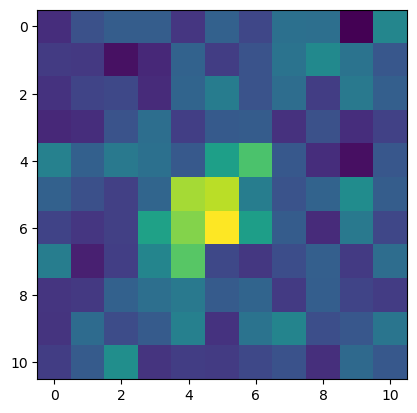

In [13]:
plt.imshow(raw_spot[3])

In [37]:
spot_dataframe

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start
0,436,5.446220,59.496261,308.276811,1,4.305350,0,"[[[1601, 1631, 1418, 1034, 1458, 1227, 680, 15...","[0, 3, 54, 303]"
1,460,6.260608,170.098509,373.048498,1,4.949140,0,"[[[1668, 1243, 1281, 2169, 1157, 1535, 1252, 1...","[0, 4, 165, 368]"
2,534,7.613012,194.801072,441.704358,1,6.018243,0,"[[[686, 967, 917, 719, 1047, 1123, 1219, 1489,...","[0, 5, 189, 436]"
3,567,7.612635,79.176097,359.388779,1,6.017945,0,"[[[2428, 2190, 1674, 1763, 1630, 1335, 751, 13...","[0, 5, 74, 354]"
4,608,9.135701,74.623712,459.234592,1,7.221961,0,"[[[577, 857, 806, 918, 1564, 874, 731, 759, 10...","[0, 7, 69, 454]"
...,...,...,...,...,...,...,...,...,...
9956,642,19.532418,177.925660,508.105274,167,2851.964126,171,None,"[166, 17, 172, 503]"
9957,643,18.599822,185.963800,453.122299,167,2851.226889,171,"[[[1240, 1086, 733, 1062, 1252, 916, 1485, 138...","[166, 16, 180, 448]"
9958,644,18.855954,217.566891,404.300960,167,2851.429367,171,"[[[764, 436, 538, 986, 418, 901, 995, 402, 624...","[166, 16, 212, 399]"
9959,649,19.666003,109.451826,171.390705,167,2852.069727,171,None,"[166, 17, 104, 166]"


In [55]:
test_fit = fitting.fit_gaussian_3d_sym_xy(
    raw_spot,
    centroid_guess=[2, 5, 5],
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
)

In [56]:
test_fit

(array([2.7964325 , 5.97632355, 5.53704278]),
 0.976720121523076,
 0.7226068795672654,
 3268.048976077364,
 1038.3781771709055,
 31694361.18306023)

In [97]:
from spot_analysis.fitting import fit_gaussian_3d_sym_xy

In [20]:
spot_row = spot_dataframe.iloc[40]

In [21]:
spot_row[["z", "y", "x"]].values - spot_row["coordinates_start"][1:]

array([2.409241420830824, 5.627370559903667, 5.029161649608682],
      dtype=object)

In [98]:
from functools import partial


def _fit_spot_dataframe_row(
    row,
    *,
    sigma_x_y_guess,
    sigma_z_guess,
    amplitude_guess,
    offset_guess,
    method,
    **kwargs,
):
    spot_data = row["raw_spot"]
    spatial_coordinates_start = row["coordinates_start"][1:]
    centroid_guess = row[["z", "y", "x"]].values - spatial_coordinates_start

    fit_results = fit_gaussian_3d_sym_xy(
        spot_data,
        centroid_guess=centroid_guess,
        sigma_x_y_guess=sigma_x_y_guess,
        sigma_z_guess=sigma_z_guess,
        amplitude_guess=amplitude_guess,
        offset_guess=amplitude_guess,
        method=method,
        **kwargs,
    )

    fit_relative_centroid = fit_results[0]
    
    # Restore initial centroid values if fit failed
    if np.isnan(fit_relative_centroid).any():
        fit_relative_centroid = centroid_guess
        
    refined_centroid = spatial_coordinates_start + fit_relative_centroid

    out = (*refined_centroid, *fit_results[1:])

    return out

In [45]:
test_fit = _fit_spot_dataframe_row(
    spot_row,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
)

In [46]:
test_fit

(13.796428557459363,
 83.97631954859006,
 251.5370496545442,
 0.9767170742862161,
 0.7226068084789012,
 3268.0583189905738,
 1038.3783804130057,
 31694361.1784148)

In [99]:
def add_fits_spots_dataframe(
    spot_dataframe,
    *,
    sigma_x_y_guess,
    sigma_z_guess,
    amplitude_guess=None,
    offset_guess=None,
    method='trf',
    **kwargs,
):
    fit_spot_row_func = partial(_fit_spot_dataframe_row, sigma_x_y_guess=sigma_x_y_guess, sigma_z_guess=sigma_z_guess, amplitude_guess=amplitude_guess, offset_guess=offset_guess, method=method)
    spot_dataframe[["z", "y", "x", "sigma_x_y", "sigma_z", "amplitude", "offset", "cost"]] = spot_dataframe.apply(fit_spot_row_func, result_type='expand', axis=1)

    return None

In [100]:
add_fits_spots_dataframe(
    spot_dataframe,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
)

In [103]:
spot_dataframe["sigma_x_y"].values

array([0.84211045, 0.82273122, 0.93730752, ..., 1.09720643,        nan,
              nan])

In [104]:
import matplotlib.plt.hist(spot_dataframe["sigma_x_y"].values, bins=100)pyplot as plt

(array([2.000e+00, 2.000e+00, 1.000e+01, 7.400e+01, 1.970e+02, 5.280e+02,
        8.270e+02, 1.105e+03, 1.369e+03, 1.357e+03, 1.159e+03, 9.080e+02,
        6.260e+02, 4.240e+02, 2.570e+02, 1.750e+02, 1.390e+02, 7.700e+01,
        4.600e+01, 3.700e+01, 1.500e+01, 1.600e+01, 1.400e+01, 1.100e+01,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

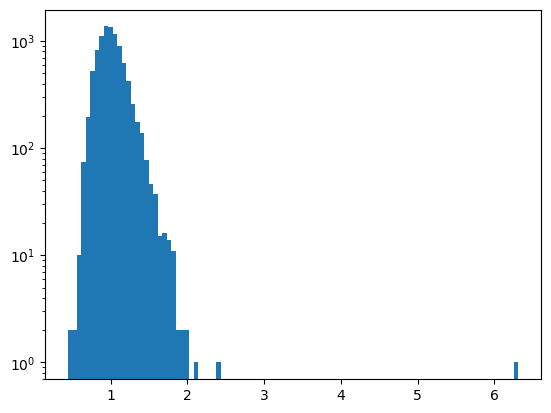

In [109]:
plt.hist(spot_dataframe["sigma_x_y"].values, bins=100, log=True)

(array([2.000e+00, 2.000e+00, 1.000e+01, 7.400e+01, 1.970e+02, 5.280e+02,
        8.270e+02, 1.105e+03, 1.369e+03, 1.357e+03, 1.159e+03, 9.080e+02,
        6.260e+02, 4.240e+02, 2.570e+02, 1.750e+02, 1.390e+02, 7.700e+01,
        4.600e+01, 3.700e+01, 1.500e+01, 1.600e+01, 1.400e+01, 1.100e+01,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

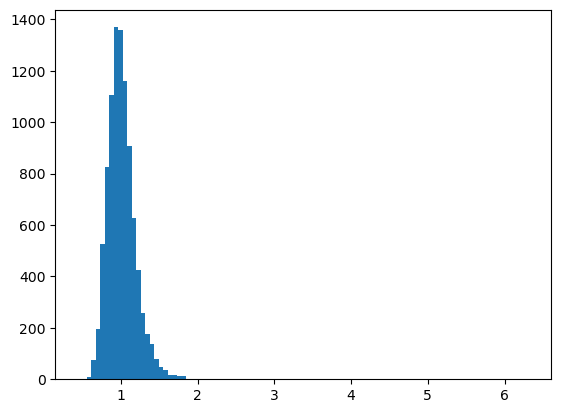

In [110]:
plt.hist(spot_dataframe["sigma_x_y"].values, bins=100, log=False)

(array([3.332e+03, 1.420e+03, 9.400e+02, 6.790e+02, 5.490e+02, 4.450e+02,
        3.700e+02, 2.830e+02, 2.320e+02, 1.810e+02, 1.480e+02, 1.080e+02,
        1.300e+02, 7.900e+01, 6.400e+01, 5.900e+01, 4.900e+01, 4.900e+01,
        2.900e+01, 2.700e+01, 1.800e+01, 1.700e+01, 2.300e+01, 1.400e+01,
        1.300e+01, 1.300e+01, 9.000e+00, 1.000e+01, 1.200e+01, 1.200e+01,
        6.000e+00, 1.100e+01, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

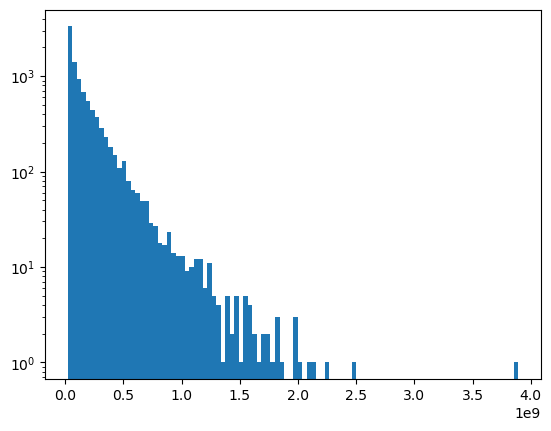

In [108]:
plt.hist(spot_dataframe["cost"].values, bins=100, log=True)

(array([3.332e+03, 1.420e+03, 9.400e+02, 6.790e+02, 5.490e+02, 4.450e+02,
        3.700e+02, 2.830e+02, 2.320e+02, 1.810e+02, 1.480e+02, 1.080e+02,
        1.300e+02, 7.900e+01, 6.400e+01, 5.900e+01, 4.900e+01, 4.900e+01,
        2.900e+01, 2.700e+01, 1.800e+01, 1.700e+01, 2.300e+01, 1.400e+01,
        1.300e+01, 1.300e+01, 9.000e+00, 1.000e+01, 1.200e+01, 1.200e+01,
        6.000e+00, 1.100e+01, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

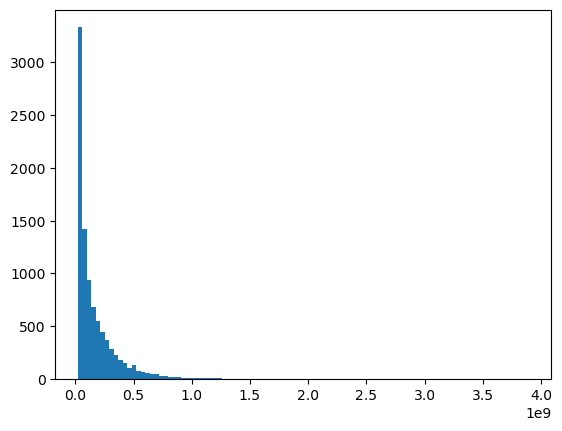

In [111]:
plt.hist(spot_dataframe["cost"].values, bins=100, log=False)

In [35]:
np.array((None,)*6)

array([None, None, None, None, None, None], dtype=object)

In [36]:
np.full(6, np.nan)

array([nan, nan, nan, nan, nan, nan])

In [40]:
np.nan_to_num(np.full(3, np.nan)) + np.arange(3)

array([0., 1., 2.])

In [96]:
reload(fitting)

<module 'spot_analysis.fitting' from '/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/spot_analysis/fitting.py'>